In [1]:
from mnist import MNIST
import numpy as np
import os

In [2]:
mnist_data = MNIST(path='./samples/', gz=True)

In [3]:
train_data = mnist_data.load_training()

In [4]:
len(train_data)

2

In [5]:
len(train_data[0])

60000

In [6]:
len(train_data[1])

60000

In [7]:
len(train_data[0][0])

784

In [8]:
#len(train_data[1][0])

In [9]:
print(type(train_data[0]), type(train_data[1]))

<class 'list'> <class 'array.array'>


load_training returns a tuple with two lists: first one containing lists of values for data points (60000 lists, each with 784 entries), and second one is a list of labels as integers (60000 integers)

In [10]:
X_train = np.array(train_data[0])
y_train = np.array(train_data[1]).reshape((-1, 1))

In [11]:
X_train.shape

(60000, 784)

In [12]:
y_train.shape

(60000, 1)

In [13]:
X_train.max()

255

In [14]:
X_train.min()

0

In [15]:
y_train.max()

9

In [16]:
y_train.min()

0

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

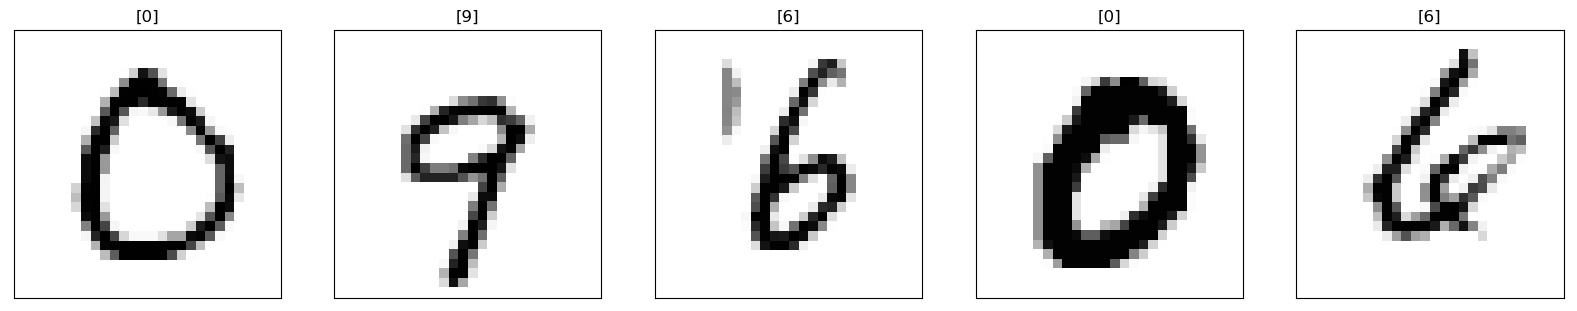

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 20), dpi=100)
for n, ax in zip(np.random.permutation(len(X_train))[:5], axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(y_train[n])
    ax.imshow(X_train[n].reshape(28, 28), cmap="Greys")

In [19]:
X_test, y_test = mnist_data.load_testing()
X_test = np.array(X_test)
y_test = np.array(y_test).reshape(-1, 1)

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [21]:
device = "cuda"

In [22]:
def normalize(input_tensor, dim=None):
    if dim is None:
        mean = input_tensor.data.mean()
        std = input_tensor.data.std()
    else:
        mean = input_tensor.data.mean(dim=dim)
        std = input_tensor.data.std(dim=dim)

    input_tensor.data = input_tensor.data - mean # mean of 0
    input_tensor.data = input_tensor.data / std.max(torch.tensor(1e-12, dtype=std.dtype, device=std.device)) # standard deviation of 1, prevent division by zero

In [23]:
def convert_and_normalize_input(X, dtype=None, device=None, dim=None):
    X_minmaxed = torch.tensor(X / 255, dtype=dtype, device=device)

    normalize(X_minmaxed, dim=dim)
    X_normalized = X_minmaxed

    return X_normalized

In [24]:
X_train = convert_and_normalize_input(X_train, dtype=torch.float64, device=device)
X_test = convert_and_normalize_input(X_test, dtype=torch.float64, device=device)

In [25]:
X_train

tensor([[-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
        [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
        [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
        ...,
        [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
        [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241],
        [-0.4241, -0.4241, -0.4241,  ..., -0.4241, -0.4241, -0.4241]],
       device='cuda:0', dtype=torch.float64)

In [26]:
X_train.shape

torch.Size([60000, 784])

In [27]:
X_test.shape

torch.Size([10000, 784])

In [28]:
def labels_to_onehot(Y, device=None):
    return torch.tensor(Y, dtype=torch.uint8, device=device).eq(torch.arange(0, 10, dtype=torch.uint8, device=device))

In [29]:
Y_train = labels_to_onehot(y_train, device=device)
Y_train.data = Y_train.data.type(torch.float64)
Y_test = labels_to_onehot(y_test, device=device)
Y_test.data = Y_test.data.type(torch.float64)

In [30]:
epsilon = 0.01

w1 = torch.tensor(torch.rand(100, X_train.shape[1], dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)
b1 = torch.tensor(torch.rand(100, 1, dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)
w2 = torch.tensor(torch.rand(10, w1.shape[0], dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)
b2 = torch.tensor(torch.rand(10, 1, dtype=torch.float64) * 2 * epsilon - epsilon, device=device, requires_grad=True)

In [31]:
w1

tensor([[ 0.0046, -0.0096,  0.0027,  ...,  0.0068,  0.0040, -0.0074],
        [-0.0097,  0.0047,  0.0099,  ..., -0.0017, -0.0010, -0.0098],
        [ 0.0050,  0.0028,  0.0087,  ..., -0.0079, -0.0042,  0.0091],
        ...,
        [ 0.0072,  0.0092, -0.0049,  ..., -0.0030, -0.0055, -0.0046],
        [-0.0042,  0.0074, -0.0079,  ...,  0.0029,  0.0086,  0.0019],
        [ 0.0020, -0.0030, -0.0096,  ..., -0.0093, -0.0005, -0.0003]],
       device='cuda:0', dtype=torch.float64, requires_grad=True)

In [123]:
def predict(probs, one_hot=False):
    preds = torch.tensor(probs.argmax(dim=1).reshape((-1, 1)), dtype=torch.uint8, device=probs.device)

    if one_hot is True:
        preds.data = preds.eq(torch.arange(0, 10, dtype=torch.uint8, device=probs.device))

    return preds


def accuracy_score(pred, true):
    assert len(pred) == len(true)

    pred = pred.cuda().argmax(dim=1)
    true = true.cuda().argmax(dim=1)

    accuracy = pred.eq(true).sum(dtype=pred.dtype).item() / float(len(true))

    return accuracy


def reset(tensors, e=0.01):
    for tensor in tensors:
        tensor.data = torch.tensor(torch.rand(tensor.size(), dtype=tensor.dtype, device=tensor.device) * 2 * e - e)


def feedforward(input_data, weight_matrices, biase_matrices=None):
    assert biase_matrices is None or len(weight_matrices) == len(biase_matrices)
    
    output = input_data.clone()
    
    for n, weights in enumerate(weight_matrices):
        output = output.mm(weights.t())
        if biase_matrices is not None:
            output = output + biase_matrices[n].t()
        output = torch.sigmoid(output)
    
    return output

def binary_class_cross_entropy_loss(pred, true, per_example=False):
    assert len(pred) == len(true)
    
    loss = torch.sum(-true * torch.log(pred) - (1 - true) * torch.log(1 - pred), dim=1, dtype=pred.dtype)
    if per_example is False:
        loss = loss.sum() / len(true)
        if loss.item() != loss.item(): # if the result is nan (probably due to 0 value inside log functions)
            loss = torch.sum(-true * torch.log(pred + 1e-12) - (1 - true) * torch.log(1 - pred + 1e-12), dtype=pred.dtype)
    
    return loss


def regularization_loss(weight_matrices, regular_coef, n_examples):
    loss = (regular_coef / (2 * n_examples)) * sum([weights.pow(2).sum() for weights in weight_matrices])
    return loss

In [33]:
def loss_function(prob, true, weight_matrices, regular_coef, n_examples):
    return binary_class_cross_entropy_loss(prob, true) + regularization_loss(weight_matrices, regular_coef, n_examples)

In [35]:
# Set up logs
train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

In [36]:
# Bundle the weights and biases into two separate lists so that I can use them for my functions
weights = [w1, w2]
biases = [b1, b2]

In [127]:
# Hyperparameters
epoch = 1000
lambda_term = 1
learning_rate = 2.0

In [128]:
tol_loss = 1e-3
tol_step = 1e-8
reset_params = False

if reset_params is True:
    reset(weights)
    reset(biases)

exit_reason = ""

backups = [{'parameters':[param.clone() for param in (weights + biases)],
            'index':len(train_loss_history),
            'train_loss':train_loss_history[-1]}]

backup_during_training = True
n_checkpoint = 10 # backup the parameters and iteration number n_checkpoint times during a full set of iterations

checkpoint_interval = epoch // n_checkpoint
for iteration in range(epoch):
    output = feedforward(X_train, weights, biases)
    loss = loss_function(output, Y_train, weights, lambda_term, len(X_train))
    
    loss.backward()
    
    for param in (weights + biases):
        param.data -= learning_rate * param.grad.data
        param.grad.data.zero_()

    train_pred = predict(output, one_hot=True)

    train_loss_history.append(loss.item())
    train_acc_history.append(accuracy_score(train_pred, Y_train))
    
    
    test_prob = feedforward(X_test, weights, biases)
    test_pred = predict(test_prob, one_hot=True)

    test_loss_history.append(binary_class_cross_entropy_loss(test_prob, Y_test).item())
    test_acc_history.append(accuracy_score(test_pred, Y_test))
    
    if (iteration + 1) % 10 == 0:
        print(f"\nIteration {iteration + 1}")
        print(f"[Training Loss = {train_loss_history[-1]:.6f}\t"
              f"Training Accuracy = {train_acc_history[-1]:.6f}]\n"
              f"[Test Loss = {test_loss_history[-1]:.6f}\t\t"
              f"Test Accuracy = {test_acc_history[-1]:.6f}]")

    if backup_during_training is True and iteration % checkpoint_interval == 0:
        backups.append({'parameters':[param.clone() for param in (weights + biases)],
                        'index':len(train_loss_history),
                        'train_loss':train_loss_history[-1]})


    if train_loss_history[-1] < tol_loss:
        exit_reason = "Loss value less than tol_loss value"
        break
    
    elif len(train_loss_history) > 1 and abs(train_loss_history[-1] - train_loss_history[-2]) < tol_step:
        exit_reason = "Loss value change less than tol_step value"
        break
    
    elif iteration == (epoch - 1):
        exit_reason = "Iteration finished"
        
print(f"\n{exit_reason}")
print(f"Training finished in {iteration + 1} iterations")
print(f"\nFinal training loss = {train_loss_history[-1]}")
print(f"Final training accuracy = {train_acc_history[-1]}")
print(f"\nFinal test loss = {test_loss_history[-1]}")
print(f"Final test accuracy = {test_acc_history[-1]}")


Iteration 10
[Training Loss = 0.066704	Training Accuracy = 0.997333]
[Test Loss = 0.168912		Test Accuracy = 0.976100]

Iteration 20
[Training Loss = 0.066499	Training Accuracy = 0.997350]
[Test Loss = 0.168892		Test Accuracy = 0.976100]

Iteration 30
[Training Loss = 0.066295	Training Accuracy = 0.997383]
[Test Loss = 0.168872		Test Accuracy = 0.976100]

Iteration 40
[Training Loss = 0.066093	Training Accuracy = 0.997417]
[Test Loss = 0.168853		Test Accuracy = 0.976200]

Iteration 50
[Training Loss = 0.065892	Training Accuracy = 0.997417]
[Test Loss = 0.168835		Test Accuracy = 0.976200]

Iteration 60
[Training Loss = 0.065693	Training Accuracy = 0.997450]
[Test Loss = 0.168817		Test Accuracy = 0.976100]

Iteration 70
[Training Loss = 0.065496	Training Accuracy = 0.997483]
[Test Loss = 0.168800		Test Accuracy = 0.976100]

Iteration 80
[Training Loss = 0.065301	Training Accuracy = 0.997500]
[Test Loss = 0.168784		Test Accuracy = 0.976100]

Iteration 90
[Training Loss = 0.065107	Training


Iteration 700
[Training Loss = 0.055834	Training Accuracy = 0.998733]
[Test Loss = 0.168705		Test Accuracy = 0.977100]

Iteration 710
[Training Loss = 0.055716	Training Accuracy = 0.998750]
[Test Loss = 0.168716		Test Accuracy = 0.977100]

Iteration 720
[Training Loss = 0.055598	Training Accuracy = 0.998783]
[Test Loss = 0.168726		Test Accuracy = 0.977100]

Iteration 730
[Training Loss = 0.055482	Training Accuracy = 0.998800]
[Test Loss = 0.168737		Test Accuracy = 0.977100]

Iteration 740
[Training Loss = 0.055366	Training Accuracy = 0.998800]
[Test Loss = 0.168748		Test Accuracy = 0.977100]

Iteration 750
[Training Loss = 0.055252	Training Accuracy = 0.998817]
[Test Loss = 0.168759		Test Accuracy = 0.977100]

Iteration 760
[Training Loss = 0.055138	Training Accuracy = 0.998817]
[Test Loss = 0.168770		Test Accuracy = 0.977000]

Iteration 770
[Training Loss = 0.055025	Training Accuracy = 0.998833]
[Test Loss = 0.168782		Test Accuracy = 0.976900]

Iteration 780
[Training Loss = 0.054913

In [124]:
list(enumerate([backup['train_loss'] for backup in backups]))

[(0, 0.06908725931491116)]

In [125]:
are_you_sure_you_want_to_revert = False

i = 0

if are_you_sure_you_want_to_revert is True:
    for n, param in enumerate(weights + biases):
        param.data = backups[i]['parameters'][n].data
    train_loss_history = train_loss_history[:backups[i]['index']]
    train_acc_history = train_acc_history[:backups[i]['index']]
    test_loss_history = test_loss_history[:backups[i]['index']]
    test_acc_history = test_acc_history[:backups[i]['index']]

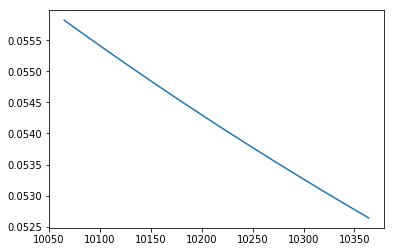

In [129]:
plt.plot(list(range(len(train_loss_history) + 1 - 300, len(train_loss_history) + 1)), train_loss_history[-300:])

In [130]:
len(train_loss_history)

10364

In [136]:
top5_incorrect = binary_class_cross_entropy_loss(feedforward(X_train, weights, biases), Y_train, per_example=True).sort(dim=0, descending=True)[1][:5].cpu().tolist()
top5_incorrect

[21601, 2676, 24798, 8729, 59915]

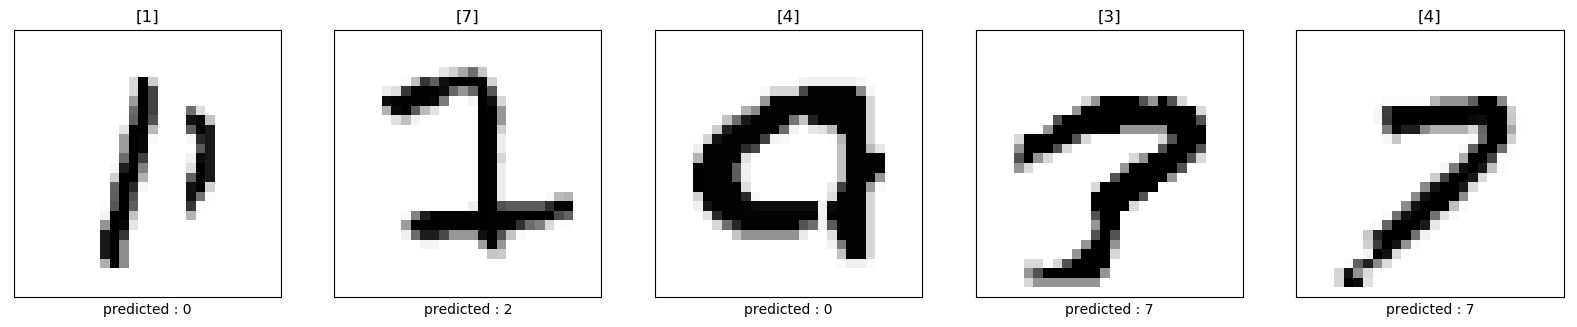

In [139]:
fig, axes = plt.subplots(nrows=1, ncols=len(top5_incorrect), figsize=(20, 20), dpi=100)
for n, ax in zip(top5_incorrect, axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(y_train[n])
    ax.set_xlabel(f"predicted : {predict(feedforward(X_train[n].unsqueeze(0), weights, biases)).item()}")
    ax.imshow(X_train[n].reshape(28, 28), cmap="Greys")

In [142]:
fig.savefig("./most_incorrect_5.png", dpi='figure', orientation='landscape')

In [143]:
top5_correct = binary_class_cross_entropy_loss(feedforward(X_train, weights, biases), Y_train, per_example=True).sort(dim=0, descending=False)[1][:5].cpu().tolist()
top5_correct

[25221, 19965, 44231, 45327, 28089]

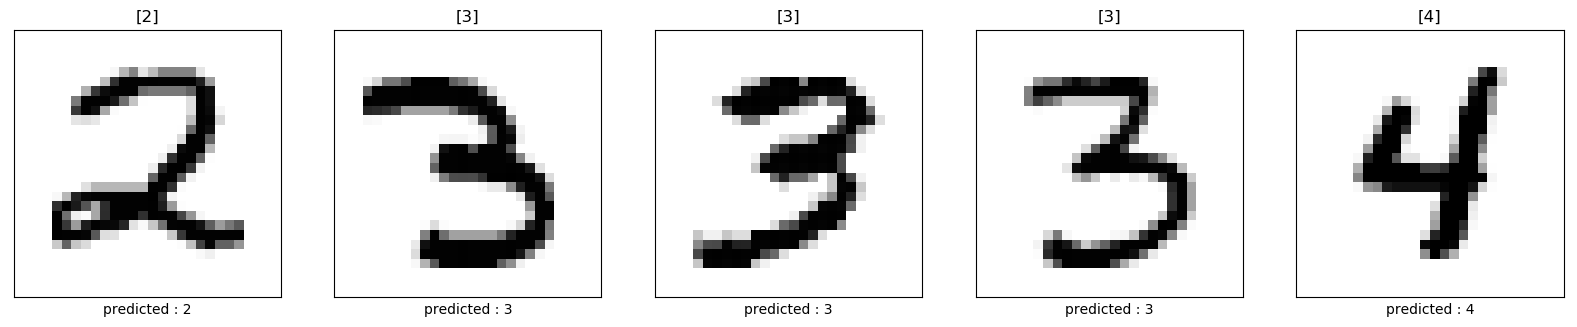

In [144]:
fig, axes = plt.subplots(nrows=1, ncols=len(top5_correct), figsize=(20, 20), dpi=100)
for n, ax in zip(top5_correct, axes):
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(y_train[n])
    ax.set_xlabel(f"predicted : {predict(feedforward(X_train[n].unsqueeze(0), weights, biases)).item()}")
    ax.imshow(X_train[n].reshape(28, 28), cmap="Greys")

In [146]:
fig.savefig("./most_correct_5.png", dpi='figure', orientation='landscape')